# Import Libraries

In [256]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# For implementing pipeline
from sklearn.pipeline import Pipeline


# For Scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# For Classification
from sklearn.neighbors import KNeighborsClassifier

# For Splitting the data for training and Validation
from sklearn.model_selection import train_test_split

# For creating model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Principal Component Analysis for Dimensionality Reduction
from sklearn.decomposition import PCA

# For Shuffling the DataFrame
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [257]:
# Take a look to the data
df = pd.read_csv("../Dataset/train.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Exploratory Data Analysis

In [258]:
# take a look to features property
missing = []
unique = []
types = []
variables = []
count = []

for item in df.columns:
    variables.append(item)
    missing.append(df[item].isnull().sum())
    unique.append(df[item].nunique())
    types.append(df[item].dtypes)
    count.append(len(df[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})   
output.sort_values("missing",ascending=False).reset_index(drop=True)

,variable,dtype,count,unique,missing
0,Credit_History,float64,614,2,50
1,Self_Employed,object,614,2,32
2,LoanAmount,float64,614,203,22
3,Dependents,object,614,4,15
4,Loan_Amount_Term,float64,614,10,14
5,Gender,object,614,2,13
6,Married,object,614,2,3
7,Loan_ID,object,614,614,0
8,Education,object,614,2,0
9,ApplicantIncome,int64,614,505,0


In [259]:
# As we can see from the table above, the Credit_History have unique values of 2. Which is 1 or 0.
# We will change it to an object
df['Credit_History'] = df['Credit_History'].astype('O')

In [260]:
# Describe the numerical data
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


In [261]:
# describe categorical data ("object")

df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,564.0,614,614
unique,614,2,2,4,2,2,2.0,3,2
top,LP001002,Male,Yes,0,Graduate,No,1.0,Semiurban,Y
freq,1,489,398,345,480,500,475.0,233,422


The percentage of Y class :  0.6872964169381107
The percentage of N class :  0.3127035830618892


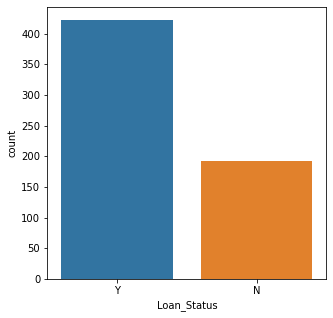

In [262]:
# Let's see if the dataset is imbalanced or not based on the target of prediction which is Loan_Status

plt.figure(figsize=(5,5))
sns.countplot(x= df['Loan_Status'],data = df)

print('The percentage of Y class : ' , (df['Loan_Status'].value_counts()[0] / len(df)))
print('The percentage of N class : ' , (df['Loan_Status'].value_counts()[1] / len(df)))

In [263]:
# it does look imbalanced, there are few method that can be used.


### Let's take a look for each feature in our dataset

#### 1. Loan_ID

In [264]:
print(df['Loan_ID'].describe())
print("Number of null values : ", df['Loan_ID'].isnull().sum())

count          614
unique         614
top       LP001002
freq             1
Name: Loan_ID, dtype: object
Number of null values :  0


Each of Loan taken individual have their own indiviudal Loan_ID. In fact this column not going impact to our training model prediction so we can drop it

#### 2. Gender

In [265]:
print(df['Gender'].describe())
print("Number of null values : ", df['Gender'].isnull().sum())
print(df['Gender'].value_counts())

count      601
unique       2
top       Male
freq       489
Name: Gender, dtype: object
Number of null values :  13
Male      489
Female    112
Name: Gender, dtype: int64


What values that should be filled in the null? There are few ways to do so, but I will use model predictions to determine which values should be filled.

`The question is which features that will be used?`

In [266]:
# Let's check the null value row and see which features that can be used. 
# If there are a lot of rows using sampling techniques or show it in countplot
samples_with_null_values_on_gender_column = df[df['Gender'].isnull()]
samples_with_null_values_on_gender_column

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
126,LP001448,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
171,LP001585,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
188,LP001644,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
314,LP002024,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N
334,LP002103,NaN,Yes,1,Graduate,Yes,9833,1833.0,182.0,180.0,1.0,Urban,Y
460,LP002478,NaN,Yes,0,Graduate,Yes,2083,4083.0,160.0,360.0,NaN,Semiurban,Y
467,LP002501,NaN,Yes,0,Graduate,No,16692,0.0,110.0,360.0,1.0,Semiurban,Y
477,LP002530,NaN,Yes,2,Graduate,No,2873,1872.0,132.0,360.0,0.0,Semiurban,N
507,LP002625,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N


- Most of these people are married. So we can't fill Gender based on `Married` column.
- Most of these people are graduated. So we can't fill Gender based on `Education` column.
- Most of these people are self employed. So we can't fill Gender based on `Self_Employed` column.
- Most of these people are having `Credit_History` and `Loan_Amount_Term` as 360 days(1 year).
- Since we are going to predict applicant's Gender, we can omit CoapplicantIncome
- So we are going predict the Gender based on `Dependents`, `ApplicantIncome`, `LoanAmount`, and `Property_Area`

In [267]:
# I will be used KNN Classifer
# Initialize Gender predictor columns list
GENDER_PREDICTOR_COLUMNS = ['Dependents', 'ApplicantIncome', 'LoanAmount', 'Property_Area', 'Gender']

samples_gender = df.copy()

#Convert categorical data to numerical data
encode = LabelEncoder()
samples_gender['Dependents'] = encode.fit_transform(samples_gender['Dependents'])
samples_gender['Property_Area'] = encode.fit_transform(samples_gender['Property_Area'])


# Let's get the rows not having null values on gender column
samples_without_null_values_on_gender_column = samples_gender[~samples_gender['Gender'].isnull()][GENDER_PREDICTOR_COLUMNS]
# Dropping samples having null values in predictor columns
samples_without_null_values_on_gender_column = samples_without_null_values_on_gender_column.dropna(how = 'any')
#Will be used as train data


# Building Gender Predictor using Pipeline and KNeigborsClassifiers
Gender_predictor = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('gen_predictor', KNeighborsClassifier(n_neighbors = 2))
])
Gender_predictor.fit(samples_without_null_values_on_gender_column.iloc[:, :-1].values,
                    samples_without_null_values_on_gender_column.iloc[:, -1].values)



Pipeline(steps=[('scaler', StandardScaler()),
                ('gen_predictor', KNeighborsClassifier(n_neighbors=2))])

In [268]:
#Fill the null values with predicted values from knn model
for row in range(samples_gender.shape[0]):
    if(samples_gender.loc[row,'Gender'] is np.nan):
        X = samples_gender.loc[row, GENDER_PREDICTOR_COLUMNS[:-1]].values.reshape(1, -1)
        df.loc[row,'Gender'] = Gender_predictor.predict(X)
      

In [269]:
df['Gender'].isnull().sum()

0

#### 3. Married

In [270]:
# TODO : Describing Married column
print(df['Married'].describe())
print("Number of null values : ", df['Married'].isnull().sum())
print(df['Married'].value_counts())

count     611
unique      2
top       Yes
freq      398
Name: Married, dtype: object
Number of null values :  3
Yes    398
No     213
Name: Married, dtype: int64


In [271]:
df[df['Married'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


As we can see there are `Graduate`, `No Self_Employed`       

In [272]:
# Lets see what Married people will be look like
df[df['Married'] == 'Yes'].describe(include = 'all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,398,398,398,390,398,380,398.000000,398.000000,384.000000,389.000000,362.0,398,398
unique,398,2,1,4,2,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001003,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,365,398,174,309,326,NaN,NaN,NaN,NaN,305.0,151,285
mean,NaN,NaN,NaN,NaN,NaN,NaN,5629.173367,1794.632965,155.750000,336.987147,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6989.254425,2039.962354,89.934267,66.739163,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,17.000000,12.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2817.500000,0.000000,108.000000,360.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3854.500000,1625.000000,132.000000,360.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5820.500000,2464.000000,178.500000,360.000000,NaN,NaN,NaN


- There are 398 married applicants, among them 309 are Graduated, 326 are Not Self_Employed, 151 semi-urban.
- Applicant Income and Co Appliant Income are most similar
- From this, we can assume that all missing samples as Married.


In [273]:
df[df['Married'] == 'No'].describe(include = 'all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,213,213,213,209,213,199,213.000000,213.000000,206.000000,208.000000,199.0,213,213
unique,213,2,1,4,2,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001002,Male,No,0,Graduate,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,133,213,171,168,171,NaN,NaN,NaN,NaN,167.0,80,134
mean,NaN,NaN,NaN,NaN,NaN,NaN,4970.384977,1316.558685,128.883495,351.115385,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,4004.332801,4097.418521,74.385981,60.398565,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,416.000000,0.000000,9.000000,36.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2917.000000,0.000000,88.000000,360.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3750.000000,0.000000,115.500000,360.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5417.000000,1783.000000,144.750000,360.000000,NaN,NaN,NaN


In [274]:
df['Married'] = df['Married'].fillna('Yes')
# TODO : encoding categorical values into numerical values
df['Married'] = df['Married'].apply(lambda x : {'Yes' : 1, 'No' : 0}[x])

In [275]:
df['Married'].isnull().sum()

0

#### 4 .Education

In [276]:
# TODO : Descriptive Statistics on EDucation columns
print(df['Education'].describe())
print(df['Education'].isnull().sum())
print(df['Education'].value_counts())

count          614
unique           2
top       Graduate
freq           480
Name: Education, dtype: object
0
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


In [277]:
# TODO : Encoding categorical data into Numerical data
df['Education'] = df['Education'].apply(lambda x : {'Graduate' : 1, 'Not Graduate' : 0}[x])

#### 5.Dependants

In [278]:
print(df['Dependents'].describe())
print("Number of null values : ", df['Dependents'].isnull().sum())
print("Unique values : ", df['Dependents'].unique())
print("Value counts : \n", df['Dependents'].value_counts())

count     599
unique      4
top         0
freq      345
Name: Dependents, dtype: object
Number of null values :  15
Unique values :  ['0' '1' '2' '3+' nan]
Value counts : 
 0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


In [279]:
df[df['Dependents'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,1,NaN,1,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,1,NaN,1,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,1,NaN,1,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,1,NaN,0,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,1,NaN,1,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
293,LP001945,Female,0,NaN,1,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,LP001972,Male,1,NaN,0,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,LP002100,Male,0,NaN,1,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,LP002106,Male,1,NaN,1,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,1,NaN,0,No,3523,3230.0,152.0,360.0,0.0,Rural,N


In [280]:
# Most of them are married. So we can fill the null values on Dependents column based on Married column
for row in range(df.shape[0]):
    if df.loc[row, 'Dependents'] is np.nan:
        df.loc[row, 'Dependents'] = str(df.loc[row, 'Married'])
# TODO : Encoding Categorical data into NUmerical Data
df['Dependents'] = df['Dependents'].apply(lambda x : {'0' : 0, '1' : 1, '2' : 2, '3+' : 3}[x])

#### 6. Self_Employed

In [281]:
print(df['Self_Employed'].describe())
print("Number of null values : ", df['Self_Employed'].isnull().sum())
print("Unique values : ", df['Self_Employed'].unique())
print("Value counts : \n", df['Self_Employed'].value_counts())

count     582
unique      2
top        No
freq      500
Name: Self_Employed, dtype: object
Number of null values :  32
Unique values :  ['No' 'Yes' nan]
Value counts : 
 No     500
Yes     82
Name: Self_Employed, dtype: int64


In [282]:
print(df[df['Self_Employed'].isnull()])
print(df[df['Self_Employed'].isnull()]['Education'].value_counts())

      Loan_ID  Gender  Married  Dependents  Education Self_Employed  \
11   LP001027    Male        1           2          1           NaN   
19   LP001041    Male        1           0          1           NaN   
24   LP001052    Male        1           1          1           NaN   
29   LP001087  Female        0           2          1           NaN   
30   LP001091    Male        1           1          1           NaN   
95   LP001326    Male        0           0          1           NaN   
107  LP001370    Male        0           0          0           NaN   
111  LP001387  Female        1           0          1           NaN   
114  LP001398    Male        0           0          1           NaN   
158  LP001546    Male        0           0          1           NaN   
170  LP001581    Male        1           0          0           NaN   
218  LP001732    Male        1           2          1           NaN   
231  LP001768    Male        1           0          1           NaN   
236  L

In [283]:
df[df['Education']==1].describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480,480,480.000000,480.000000,480.0,454,480.000000,480.000000,465.000000,472.000000,443.0,480,480
unique,480,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2.0,3,2
top,LP001002,Male,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,1.0,Semiurban,Y
freq,1,386,NaN,NaN,NaN,389,NaN,NaN,NaN,NaN,380.0,187,340
mean,NaN,NaN,0.650000,0.729167,1.0,NaN,5857.433333,1717.474833,154.060215,344.669492,NaN,NaN,NaN
std,NaN,NaN,0.477467,0.985057,0.0,NaN,6739.797954,3230.965850,92.883366,61.299661,NaN,NaN,NaN
min,NaN,NaN,0.000000,0.000000,1.0,NaN,150.000000,0.000000,9.000000,12.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,0.000000,1.0,NaN,2998.750000,0.000000,103.000000,360.000000,NaN,NaN,NaN
50%,NaN,NaN,1.000000,0.000000,1.0,NaN,4000.000000,1059.000000,132.000000,360.000000,NaN,NaN,NaN
75%,NaN,NaN,1.000000,1.000000,1.0,NaN,6068.750000,2337.000000,176.000000,360.000000,NaN,NaN,NaN


- Most of them are educated and most of them are not self-employed too.
- Nearly 86% percentage of the applicant are not self-employed.
- So we can fill it with not self-employed

In [284]:
df['Self_Employed'].fillna(value = 'No', inplace = True)

# TODO : Encoding Self_Employed as 1 and Not Self_Employed as 0
df['Self_Employed'] = df['Self_Employed'].apply(lambda x : {'Yes' : 1, 'No' : 0}[x])

<br><br><br>

#### 7. Applicant Income

In [285]:
# TODO : Descriptive Statistics on Applicant Income
print(df['ApplicantIncome'].describe())
# TODO : Check for null values on ApplicantIncome column
df['ApplicantIncome'].isnull().sum()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64


0

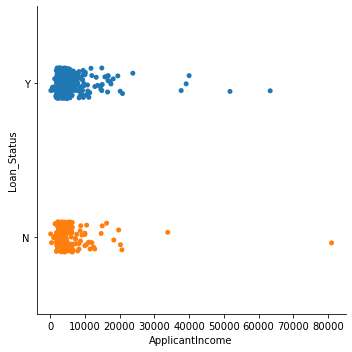

In [286]:
# TODO : Let's know the contribution of Applicant Income on determining Loan_Status 
sns.catplot(y = 'Loan_Status', x = 'ApplicantIncome', data = df)

###### From the above categorical plot, Applicant's income failed to differentiate Loan_Status. For more accuracy, we may drop the Applicant Income column.

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

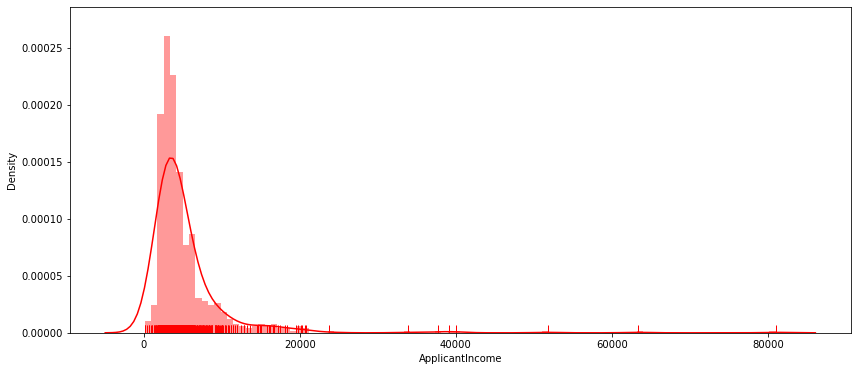

In [287]:
# TODO : Distribution of Applicant Income

plt.figure(figsize = (14, 6))
sns.distplot(df['ApplicantIncome'], rug = True, bins = 100, color='r')
# plt.savefig('../images/ApplicantIncomeDistribution.png')

- From the above distplot, most of the Applicants income less than Rs.10,000 and some considerable amount of applicants having income between Rs.10,000 and Rs.20,000.

<br><br><br>

#### 8. Co-applicant Income

In [288]:
df['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [289]:
df['CoapplicantIncome'].isnull().sum()

0

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Density'>

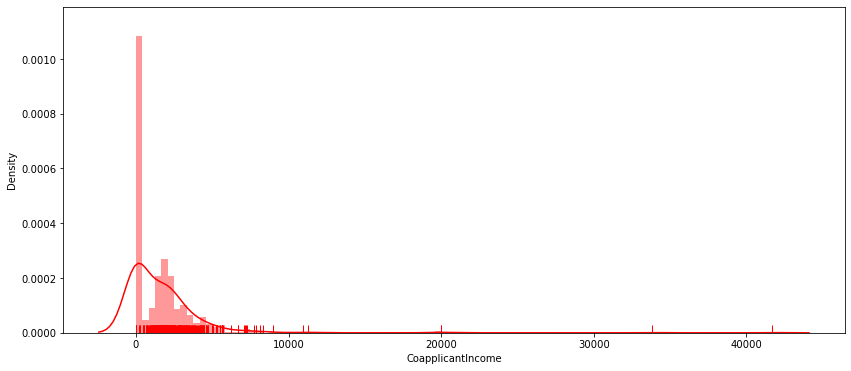

In [290]:
plt.figure(figsize = (14, 6))
sns.distplot(df['CoapplicantIncome'], rug = True, bins = 100, color='r')
# rug=True: When rug is set to True, small vertical lines ("rug plots") are drawn at each observation.
# bins=100: This sets the number of bins (intervals) for the histogram. In this case, it's set to 100.

<br><br><br>

#### 9. LoanAmount

In [291]:
# TODO : Descriptive Statistics on LoanAmount
df['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

<AxesSubplot:xlabel='LoanAmount', ylabel='Density'>

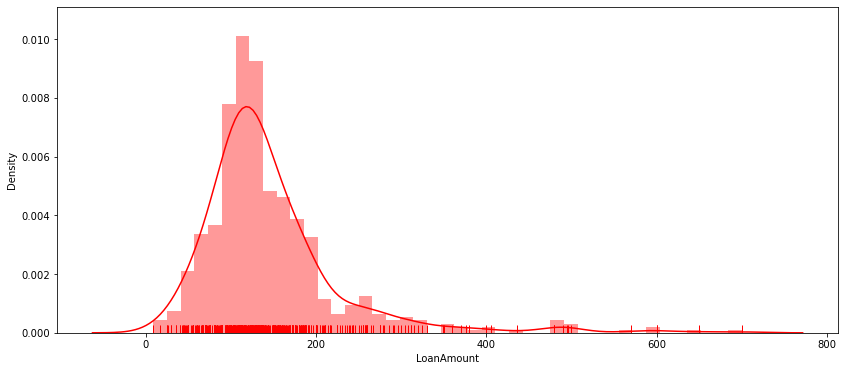

In [292]:
# TODO : Distribution of LoanAmount
plt.figure(figsize = (14, 6))
sns.distplot(df['LoanAmount'], rug = True, color = 'r')
# plt.savefig('../images/LoanAmountDistribution.png')

In [293]:
# TODO : Count of Null values on LoanAmount column
df['LoanAmount'].isnull().sum()

22

In [294]:
loan_yes_mean = np.mean(df[df['Loan_Status'] == 'Y']['LoanAmount'])
loan_no_mean = np.mean(df[df['Loan_Status'] == 'N']['LoanAmount'])
loan_no_mean

151.22099447513813

##### For yes in Loan_Status, average LoanAmount is 151.22 and no in Loan_Status, average LoanAmount is 144.29.

In [295]:
df.loc[df['Loan_Status'] == 'Y', 'LoanAmount'] = df.loc[df['Loan_Status'] == 'Y', 'LoanAmount'].fillna(loan_yes_mean)
df.loc[df['Loan_Status'] == 'N', 'LoanAmount'] = df.loc[df['Loan_Status'] == 'N', 'LoanAmount'].fillna(loan_no_mean)


<br><br><br>

#### 10. Loan_Amount_Term

In [296]:
df['Loan_Amount_Term'].describe()

count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64

In [297]:
df['Loan_Amount_Term'].isnull().sum()

14

In [298]:
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

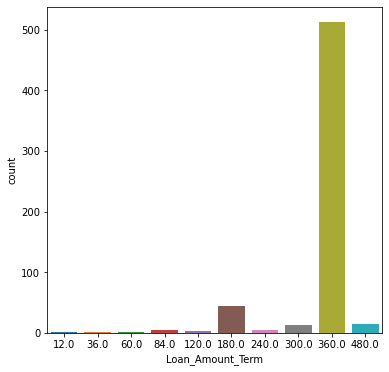

In [299]:
plt.figure(figsize=(6, 6))
sns.countplot(x = 'Loan_Amount_Term', data = df)
# plt.savefig('../images/term_counts.png')
plt.show()

##### Most of the applicants which is nearly 83 % of applicant chosen to Loan_Amount_Term of 360.

In [300]:
df[~df['Loan_Amount_Term'].isnull()].groupby('Loan_Status').describe().T.loc['Loan_Amount_Term']

Loan_Status,N,Y
count,186.000000,414.000000
mean,344.064516,341.072464
std,69.238921,63.247770
min,36.000000,12.000000
25%,360.000000,360.000000
50%,360.000000,360.000000
75%,360.000000,360.000000
max,480.000000,480.000000


##### For both status of Loan_Status, the average Loan_Amount_Term is approximately. Let's fill them with the value of 360.

In [301]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(value = 360)

<br><br><br>

##### 11. Credit_History

In [302]:
df['Credit_History'].describe()

count     564.0
unique      2.0
top         1.0
freq      475.0
Name: Credit_History, dtype: float64

In [303]:
df['Credit_History'].isnull().sum()

50

In [304]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

##### Since 78 % applicants having the Credit_History, we can fill the null values with 1.0

In [311]:
# TODO : Filling null values on Credit_History
df['Credit_History'] = df['Credit_History'].fillna(value = 1.0)

<br><br><br>

#### 12. Property_Area

In [312]:
df['Property_Area'].describe()

count           614
unique            3
top       Semiurban
freq            233
Name: Property_Area, dtype: object

In [313]:
df['Property_Area'].isnull().sum()

0

In [314]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [318]:
df['Property_Area'] = encode.fit_transform(df['Property_Area'])
df['Property_Area']

0      2
1      0
2      2
3      2
4      2
      ..
609    0
610    0
611    2
612    2
613    1
Name: Property_Area, Length: 614, dtype: int32

#### Finally we replaced all the null values with suitable values.

In [319]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<br><br><br><br><br><br>

## Feature Selection